# **Example 6.2.4 (Machine Translation with encoder-decoder attention)**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:

# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [3]:
import os
import re
import time
import math
import random
import unicodedata

import numpy as np
import pandas as pd

from tqdm import tqdm

import spacy
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
SEED = 28

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
data_df = pd.read_csv('Data/deu.txt', sep='\t', usecols=[0, 1])
data_df.columns = ['en', 'de']
data_df.head()

,en,de
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Run.,Lauf!
4,Wow!,Potzdonner!


C:\Users\aswathyr\AppData\Local\Temp\ipykernel_31808\3445379438.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_df['en'].str.split().apply(len))
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_31808\3445379438.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_df['de'].str.split()

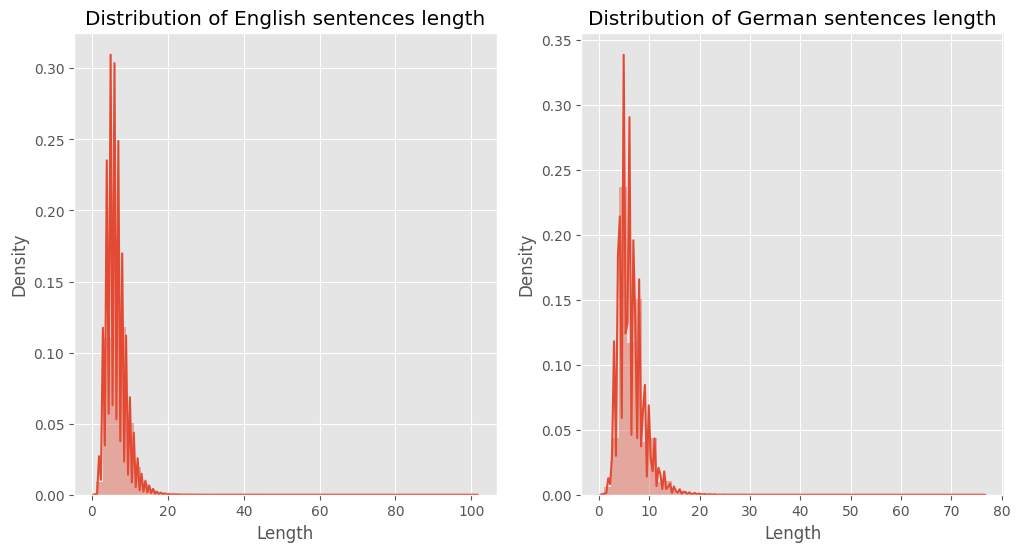

In [6]:
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
sns.distplot(data_df['en'].str.split().apply(len))
plt.title('Distribution of English sentences length')
plt.xlabel('Length')

plt.style.use('ggplot')
plt.subplot(1, 2, 2)
sns.distplot(data_df['de'].str.split().apply(len))
plt.title('Distribution of German sentences length')
plt.xlabel('Length')
plt.show()

In [7]:
seq_len_en = 20
seq_len_de = 20

In [8]:
train_df, valid_df = train_test_split(data_df, test_size=0.1, shuffle=True, random_state=28)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(train_df.shape)
print(valid_df.shape)

(199378, 2)
(22154, 2)


In [9]:
for i in range(len(train_df)-5, len(train_df)):
    print(f'ENGLISH:\n{train_df.iloc[i]["en"]},\nGERMAN:\n{train_df.iloc[i]["de"]}\n{"="*92}')

ENGLISH:
I have the house all to myself.,
GERMAN:
Ich habe das Haus ganz für mich allein.
ENGLISH:
He lives in a big house.,
GERMAN:
Er wohnt in einem großen Haus.
ENGLISH:
This medicine tastes awful.,
GERMAN:
Diese Medizin schmeckt furchtbar.
ENGLISH:
You have to go there whether you like it or not.,
GERMAN:
Sie müssen sich dorthin begeben, ob es Ihnen gefällt oder nicht.
ENGLISH:
It's absolutely true.,
GERMAN:
Das ist die volle Wahrheit.


In [10]:
class Vocabulary:
    def __init__(self, freq_threshold=2, language='en', preprocessor=None, reverse=False):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.tokenizer = spacy.load(language)
        self.freq_threshold = freq_threshold
        self.preprocessor = preprocessor
        self.reverse = reverse

    def __len__(self):
        return len(self.itos)

    def tokenize(self, text):
        if self.reverse:
            return [token.text.lower() for token in self.tokenizer.tokenizer(text)][::-1]
        else:
            return [token.text.lower() for token in self.tokenizer.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = len(self.itos)

        for sentence in sentence_list:
            # Preprocess the sentence using given preprocessor.
            if self.preprocessor:
                sentence = self.preprocessor(sentence)

            for word in self.tokenize(sentence):
                if word in frequencies:
                    frequencies[word] += 1
                else:
                    frequencies[word] = 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]



In [11]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()
    return w

In [12]:
%%time
# Build vocab using training data
freq_threshold = 2
en_vocab = Vocabulary(freq_threshold=freq_threshold, language="en_core_web_sm", preprocessor=preprocess_sentence, reverse=False)
de_vocab = Vocabulary(freq_threshold=freq_threshold, language="de_core_news_sm", preprocessor=preprocess_sentence, reverse=True)

# build vocab for both english and german
en_vocab.build_vocabulary(train_df["en"].tolist())
de_vocab.build_vocabulary(train_df["de"].tolist())

CPU times: total: 8.42 s
Wall time: 8.53 s


In [13]:
class CustomTranslationDataset(Dataset):
    def __init__(self, df, en_vocab, de_vocab):
        super().__init__()
        self.df = df
        self.en_vocab = en_vocab
        self.de_vocab = de_vocab

    def __len__(self):
        return len(self.df)

    def _get_numericalized(self, sentence, vocab):
        """Numericalize given text using prebuilt vocab."""
        numericalized = [vocab.stoi["<sos>"]]
        numericalized.extend(vocab.numericalize(sentence))
        numericalized.append(vocab.stoi["<eos>"])
        return numericalized
    def __getitem__(self, index):
        en_numericalized = self._get_numericalized(self.df.iloc[index]["en"], self.en_vocab)
        de_numericalized = self._get_numericalized(self.df.iloc[index]["de"], self.de_vocab)

        return torch.tensor(de_numericalized), torch.tensor(en_numericalized)

In [14]:
class CustomCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        src = [item[0] for item in batch]
        src = pad_sequence(src, batch_first=False, padding_value=self.pad_idx)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return src, targets

In [15]:
BATCH_SIZE = 128

# Define dataset and dataloader
train_dataset = CustomTranslationDataset(train_df, en_vocab, de_vocab)
valid_dataset = CustomTranslationDataset(valid_df, en_vocab, de_vocab)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=en_vocab.stoi["<pad>"])
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=en_vocab.stoi["<pad>"])
)

In [16]:
fun_de = np.vectorize(lambda x: de_vocab.itos[x])
fun_en = np.vectorize(lambda x: en_vocab.itos[x])

In [17]:
print(f"Unique tokens in source (de) vocabulary: {len(de_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(en_vocab)}")

Unique tokens in source (de) vocabulary: 18315
Unique tokens in target (en) vocabulary: 10655


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, n_layers, bidirectional=True, dropout=0.0 if n_layers==1 else dropout)
        self.fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        outputs, hidden_state = self.gru(x)
        # Combine the forward and backward RNN's hidden states to be input to decoder
        hidden_state = torch.tanh(self.fc(torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)))
        return outputs, hidden_state
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(3*hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_state, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # repeat decoder hidden state src_len times
        hidden_state = hidden_state.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attention(torch.cat((hidden_state, encoder_outputs), dim = 2)))

        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, attention, dropout=0.2):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.attention = attention
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim+(hidden_dim*2), hidden_dim, n_layers, dropout=0.0 if n_layers==1 else dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*3 + emb_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)

        #input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]

        a = self.attention(hidden, encoder_outputs)

        #a = [batch size, src len]

        a = a.unsqueeze(1)

        #a = [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(a, encoder_outputs)

        #weighted = [batch size, 1, enc hid dim * 2]

        weighted = weighted.permute(1, 0, 2)

        #weighted = [1, batch size, enc hid dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)

        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]

        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))

        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]

        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]

        return prediction, hidden.squeeze(0)

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        assert self.encoder.hidden_dim == decoder.hidden_dim
        assert self.encoder.n_layers == decoder.n_layers
    def forward(self, x, y, teacher_forcing_ratio=0.75):

      target_len = y.shape[0]
      batch_size = y.shape[1]
      target_vocab_size = self.decoder.output_dim  # Output dim

      outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

      # Encode the source text using encoder. Last hidden state of encoder is context vector.
      encoder_outputs, hidden_state = self.encoder(x)

      # First input is <sos>
      input = y[0,:]

      # Decode the encoded vector using decoder
      for t in range(1, target_len):
          output, hidden_state = self.decoder(input, hidden_state, encoder_outputs)
          outputs[t] = output
          teacher_force = random.random() < teacher_forcing_ratio
          pred = output.argmax(1)
          input = y[t] if teacher_force else pred
      return outputs

In [20]:
# Initialize all models
input_dim = len(de_vocab)
output_dim = len(en_vocab)
emb_dim = 256
hidden_dim = 512
n_layers = 1
dropout = 0.5

attention = Attention(hidden_dim)
encoder = Encoder(input_dim, emb_dim, hidden_dim, n_layers, dropout)
decoder = Decoder(output_dim, emb_dim, hidden_dim, n_layers, attention, dropout)
model = EncoderDecoder(encoder, decoder).to(device)

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(18315, 256)
    (gru): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attention): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(10655, 256)
    (gru): GRU(1280, 512)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=1792, out_features=10655, bias=True)
  )
)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 32,954,015 trainable parameters


In [23]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=en_vocab.stoi["<pad>"])

In [24]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, batch in tqdm(enumerate(iterator), total=len(iterator), position=0, leave=True):
        src = batch[0].to(device)
        trg = batch[1].to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator), total=len(iterator), position=0, leave=True):
            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


In [26]:
def inference(model, sentence):
    model.eval()
    result, attentions = [], []

    with torch.no_grad():
        sentence = sentence.to(device)

        encoder_outputs, hidden_state = model.encoder(sentence)

        # First input to decoder is "<sos>"
        inp = torch.tensor([en_vocab.stoi["<sos>"]]).to(device)

        # Decode the encoded vector using decoder until max length is reached or <eos> is generated.
        for t in range(1, seq_len_en):
            attention = model.decoder.attention(hidden_state, encoder_outputs)
            output, hidden_state = model.decoder(inp, hidden_state, encoder_outputs)
            pred = output.argmax(1)
            if pred == en_vocab.stoi["<eos>"]:
                break
            result.append(en_vocab.itos[pred.item()])
            inp = pred
            attentions.append(attention.cpu().detach().numpy().ravel())

    return " ".join(result), attentions

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
for sample_batch in valid_loader:
    break

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

sample_source = ' '.join([word for word in fun_de(sample_batch[0][:, 101]) if word not in ["<pad>", "<sos>", "<eos>"]])
sample_target = ' '.join([word for word in fun_en(sample_batch[1][:, 101]) if word not in ["<pad>", "<sos>", "<eos>"]])

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Sample Source (German): {sample_source}')
    print(f'\t Sample Target (English): {sample_target}')
    print(f'\t Generated: {inference(model, sample_batch[0][:, 101].reshape(-1, 1))[0]}\n')

In [ ]:
# Load the best model.
model_path = "./best_model.pt"
model.load_state_dict(torch.load(model_path))

In [ ]:
for idx in range(5):
    print(f'ACTUAL GERMAN: {" ".join([word for word in fun_de(sample_batch[0][:, idx]) if word not in ["<pad>", "<sos>", "<eos>"]])}')
    print(f'ACTUAL ENGLISH: {" ".join([word for word in fun_en(sample_batch[1][:, idx]) if word not in ["<pad>", "<sos>", "<eos>"]])}')
    print(f'PREDICTED ENGLISH: {inference(model, sample_batch[0][:, idx].reshape(-1, 1))[0]}')
    print("="*92)

In [ ]:
def plot_attention_map(sentence):
    sentence = sentence.reshape(-1, 1)
    translated, attentions = inference(model, sentence)
    sentence = sentence.cpu().detach().numpy().ravel()
    sent_len = len(sentence[sentence != 0])

    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.imshow(np.array(attentions)[:, :sent_len], cmap='gray', interpolation='nearest')
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+[word for word in fun_de(sentence) if word not in ["<pad>"]], rotation=45)
    ax.set_yticklabels(['']+translated.split())

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid(False)
    plt.savefig("attent_map.pdf")
    plt.show()

In [ ]:
plot_attention_map(sample_batch[0][:, 15])